In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Converting 2021 BRFSS Dataframe Columns to appropriate datatype

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [13]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [14]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [15]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# 2019 indexed with common columns
brfss_df = modeldf2019[common_columns]


In [16]:
#Lets clean up 2019 dataset and keep as training datset

In [17]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [18]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  210771 non-null  category
 1    STATERE1  71738 non-null   category
 2    LADULT1   71738 non-null   category
 3    COLGSEX   21 non-null      category
 4    LANDSEX   30365 non-null   category
 5    RESPSLCT  36285 non-null   category
 6    SAFETIME  139033 non-null  category
 7    CADULT1   139033 non-null  category
 8    CELLSEX   139026 non-null  category
 9    HHADULT   139028 non-null  float64 
 10   SEXVAR    210771 non-null  category
 11   GENHLTH   210753 non-null  category
 12   PHYSHLTH  210750 non-null  category
 13   MENTHLTH  210761 non-null  category
 14   POORHLTH  116171 non-null  float64 
 15   PRIMINSR  210764 non-null  category
 16   MEDCOST1  210765 non-null  category
 17   CHECKUP1  210763 non-null  category
 18   BPMEDS    81278 non-null   category
 19   

In [19]:
#Lets make a copy of the 2019 DATAFRAME
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [20]:
processed_features_df.drop(columns='MMSANAME',inplace=True)

#### REPLACE NUMERIC CATEGORICAL COLUMNS WITH ACTUAL CATEGORIES FROM QUESTIONNAIRE 

In [22]:
#'_INCOMG1'
#'_RACE'
#'_AGEG5YR'
#'_SEX'
#'HEIGHT3'
#'WEIGHT2'
#'DIABETE4'

diabetes_replace = {1:'yes', 2:'yes', 3:'no', 4:'yes', 7:np.nan, 9:np.nan}
income_replace = {1:'<15k', 2:'15k-25k', 3:'25k-35k', 4:'35k-50k', 5:'>50k',9:np.nan}
race_replace = {1:'white', 2:'black', 3:'native american', 4:'asian', 5:'native hawaiian/pacific islander', 6:'other race only', 7:'multiracial', 8:'hispanic', 9:'refused/unknown'}
age_replace = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 10:'65-69', 11:'70-74', 12:'75-79', 13:'80+', 14:np.nan}
sex_replace = {1:'male', 2:'female'}
heart_disease_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
heart_attack_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
stroke_replace =  {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
general_health_replace = {1:'excellent', 2:'very good', 3:'good', 4:'fair', 5:'poor', 7:np.nan, 9:np.nan}
physical_health_replace = {88: 0, 77: np.nan, 99: np.nan}
mental_health_replace = {88: 0, 77: np.nan, 99: np.nan}
#doctor_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
medical_costs_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
checkup_replace = {1:'1 year', 2:'2 years', 3:'5 years', 4:'>5 years', 7:'unknown', 8:'never', 9:np.nan}
exercise_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
marital_replace = {1:'married', 2:'divorced', 3:'widowed', 4:'separated', 5:'single', 6:'living together', 9:np.nan}
education_replace = {1:'none', 2:'1-8', 3:'9-11', 4:'12/ged', 5:'c1-3', 6:'cg', 9:np.nan}
smoking_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
alcohol_replace = {777:'yes', 888:'no', 999:'no'}


#columns left
# asthma = df['asthma3']
# depression = df['addepev2']
_MICHD

hw_replace = {7777:np.nan, 9999:np.nan}
metric = True
max_weight = 999

processed_features_df['_MICHD'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDINFR4'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDSTRK3'].replace(stroke_replace,inplace=True)
processed_features_df['ALCDAY5'].replace(alcohol_replace,inplace=True)
processed_features_df['SMOKDAY2'].replace(smoking_replace,inplace=True)
processed_features_df['EDUCA'].replace(education_replace,inplace=True)
processed_features_df['GENHLTH'].replace(general_health_replace,inplace=True)
processed_features_df['PHYSHLTH'].replace(physical_health_replace,inplace=True)
processed_features_df['MENTHLTH'].replace(mental_health_replace,inplace=True)
processed_features_df['CHECKUP1'].replace(checkup_replace,inplace=True)
processed_features_df['MEDCOST1'].replace(medical_costs_replace,inplace=True)
processed_features_df['MARITAL'].replace(marital_replace,inplace=True)
processed_features_df['EXERANY2'].replace(exercise_replace,inplace=True)
processed_features_df['_INCOMG1'].replace(income_replace,inplace=True)
processed_features_df['_RACE'].replace(race_replace,inplace=True)
processed_features_df['_AGEG5YR'].replace(age_replace,inplace=True)
processed_features_df['_SEX'].replace(sex_replace,inplace=True)
processed_features_df['HEIGHT3'].replace(hw_replace,inplace=True)
processed_features_df['WEIGHT2'].replace(hw_replace,inplace=True)
processed_features_df['DIABETE4'].replace(diabetes_replace,inplace=True)

In [61]:
processed_features_df[cat_cols]

CADULT1 SEXVAR    GENHLTH POORHLTH PRIMINSR MEDCOST1  CHECKUP1  \
1          1.0      1       good      1.0      1.0       no    1 year   
5          1.0      1       good      5.0      2.0       no   5 years   
6          1.0      1       good     88.0      2.0      yes   5 years   
344        1.0      1  excellent      1.0      1.0       no  >5 years   
346        1.0      2  excellent      2.0      1.0       no   5 years   
...        ...    ...        ...      ...      ...      ...       ...   
210766     1.0      2       fair     88.0      1.0       no    1 year   
210767     1.0      2  very good     88.0      1.0       no    1 year   
210769     1.0      2       good     10.0      1.0       no    1 year   
210770     1.0      2       good     88.0      1.0       no   5 years   
210771     1.0      1       good     88.0      1.0       no    1 year   

       CVDINFR4 CVDCRHD4 CVDSTRK3  ... _VEGRES1 _FRTLT1A _VEGLT1A _FRT16A  \
1           2.0      2.0      2.0  ...        1        1        2       1   
5           2.0      2.0      2.0  ...        1        2        1       1   
6           2.0      2.0      2.0  ...        1        2        1       1   
344         2.0      2.0      2.0  ...        1        1        2       0   
346         2.0      2.0      2.0  ...        1        1        1       1   
...         ...      ...      ...  ...      ...      ...      ...     ...   
210766      2.0      2.0      1.0  ...        1        1        1       1   
210767      2.0      2.0      2.0  ...        1        1        1       1   
210769      2.0      2.0      2.0  ...        1        1        2       1   
210770      2.0      2.0      2.0  ...        1        1        1       1   
210771      2.0      2.0      2.0  ...        1        1        1       1   

       _VEG23A _FRUITE1 _VEGETE1 _AIDTST4         STATE _HLTHPLN  
1            1        0        0      2.0  South Dakota      1.0  
5            1        0        0      2.0  South Dakota      1.0  
6            1        0        0      2.0  South Dakota      1.0  
344          1        2        0      2.0  South Dakota      1.0  
346          1        0        0      1.0  South Dakota      1.0  
...        ...      ...      ...      ...           ...      ...  
210766       1        0        0      1.0  Pennsylvania      1.0  
210767       1        0        0      2.0  Pennsylvania      1.0  
210769       1        0        0      2.0  Pennsylvania      1.0  
210770       1        0        0      1.0  Pennsylvania      1.0  
210771       1        0        0      2.0  Pennsylvania      1.0  

[54338 rows x 78 columns]

### Generate EDA Report with Original Dataset

In [24]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

### Handle Missing data

In [25]:
pd.reset_option('display.max_rows',None)

In [26]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   210750  0.999900
NUMPHON3  192684  0.914186
CAGEG     185674  0.880928
DIABAGE3  183766  0.871875
ASTHNOW   180692  0.857291
LANDSEX   180406  0.855934
RESPSLCT  174486  0.827846
PREGNANT  171430  0.813347
ARTHDIS2  144913  0.687538
LMTJOIN3  144911  0.687528
ARTHEDU   144910  0.687523
JOINPAI2  144910  0.687523
ARTHEXER  144909  0.687519
HIVTSTD3  142395  0.675591
NUMHHOL3  139607  0.662363
STATERE1  139033  0.659640
LADULT1   139033  0.659640
_PNEUMO3  134644  0.638817
_FLSHOT7  134644  0.638817
SMOKDAY2  130511  0.619208
BPMEDS    129493  0.614378
FLSHTMY3  113726  0.539571
MAXDRNKS  105730  0.501634
DRNK3GE5  105615  0.501089
AVEDRNK3  105247  0.499343
POORHLTH   94600  0.448828
CELLSEX    71745  0.340393
HHADULT    71743  0.340384
CADULT1    71738  0.340360
SAFETIME   71738  0.340360
_INCOMG1   40261  0.191018
_VEGESU1   27521  0.130573
_RFCHOL3   23836  0.113090
_FRUTSU1   23119  0.109688
VEGEDA2_   22774  0.108051
POTADA1_   22065  0.104687
_

In [27]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 105 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   139033 non-null  category
 1    HHADULT   139028 non-null  float64 
 2    SEXVAR    210771 non-null  category
 3    GENHLTH   210282 non-null  object  
 4    PHYSHLTH  205752 non-null  float64 
 5    MENTHLTH  206532 non-null  float64 
 6    POORHLTH  116171 non-null  float64 
 7    PRIMINSR  210764 non-null  category
 8    MEDCOST1  210154 non-null  object  
 9    CHECKUP1  210559 non-null  object  
 10   CVDINFR4  210763 non-null  category
 11   CVDCRHD4  210764 non-null  category
 12   CVDSTRK3  210762 non-null  category
 13   ASTHMA3   210764 non-null  category
 14   CHCSCNCR  210764 non-null  category
 15   CHCOCNCR  210763 non-null  category
 16   ADDEPEV3  210763 non-null  category
 17   CHCKDNY2  210763 non-null  category
 18   DIABETE4  210340 non-null  object  
 19   

##### Vegetable and fruit columns calculated from other veg_fruit columns 
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


#Drop redundant Columns and irreleveant columns

#REFINE THIS AS SOME COLUMNS MAY BE IMPORTANT FOR PREDICTING _RFHLTH


processed_features_df.drop(columns=['SEQNO','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7','MMSANAME'],inplace=True)

<Axes: >

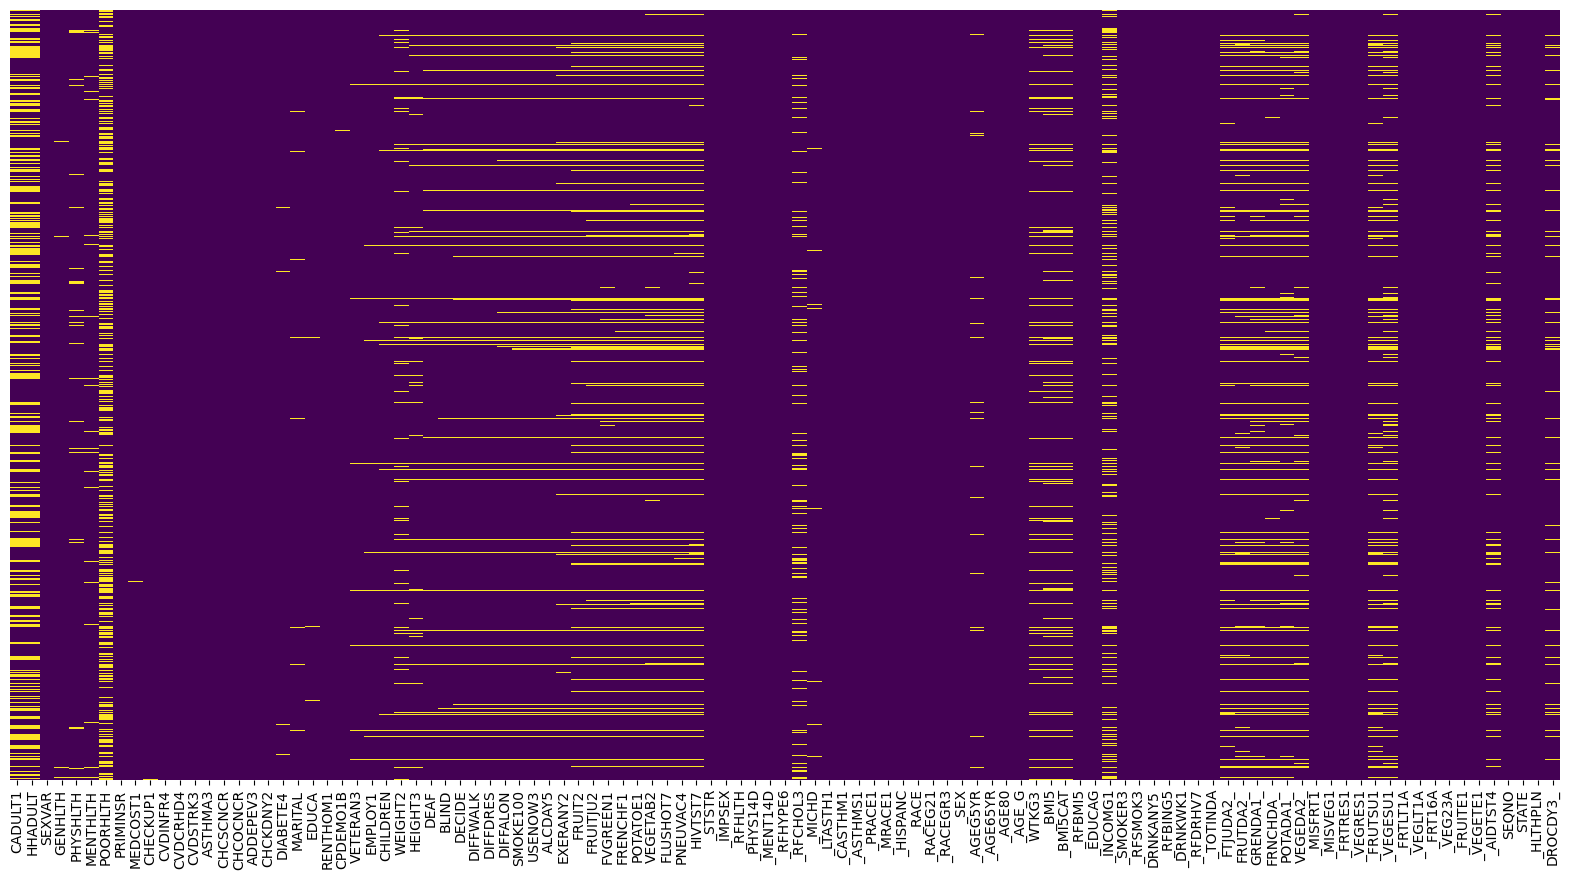

In [28]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [29]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [30]:
print(missing_data.to_string())

          Total   Percent
POORHLTH  94600  0.448828
HHADULT   71743  0.340384
CADULT1   71738  0.340360
_INCOMG1  40261  0.191018
_VEGESU1  27521  0.130573
_RFCHOL3  23836  0.113090
_FRUTSU1  23119  0.109688
VEGEDA2_  22774  0.108051
POTADA1_  22065  0.104687
_AIDTST4  21301  0.101062
HIVTST7   21301  0.101062
FRNCHDA_  20400  0.096788
GRENDA1_  20353  0.096565
FRUTDA2_  20305  0.096337
FTJUDA2_  20230  0.095981
PNEUVAC4  19921  0.094515
_BMI5CAT  19446  0.092261
_BMI5     19446  0.092261
VEGETAB2  19317  0.091649
FLUSHOT7  19314  0.091635
POTATOE1  18349  0.087057
FRENCHF1  17832  0.084604
FVGREEN1  17592  0.083465
FRUITJU2  17008  0.080694
FRUIT2    16550  0.078521
WTKG3     15829  0.075100
WEIGHT2   15820  0.075058
DROCDY3_  12301  0.058362
EXERANY2  11735  0.055677
HEIGHT3   11321  0.053712
ALCDAY5    9828  0.046629
USENOW3    8944  0.042435
SMOKE100   8552  0.040575
DIFFALON   8007  0.037989
DIFFDRES   7597  0.036044
DIFFWALK   7288  0.034578
DECIDE     6842  0.032462
BLIND      6

In [31]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [32]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [33]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [34]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [35]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [36]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [37]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [38]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

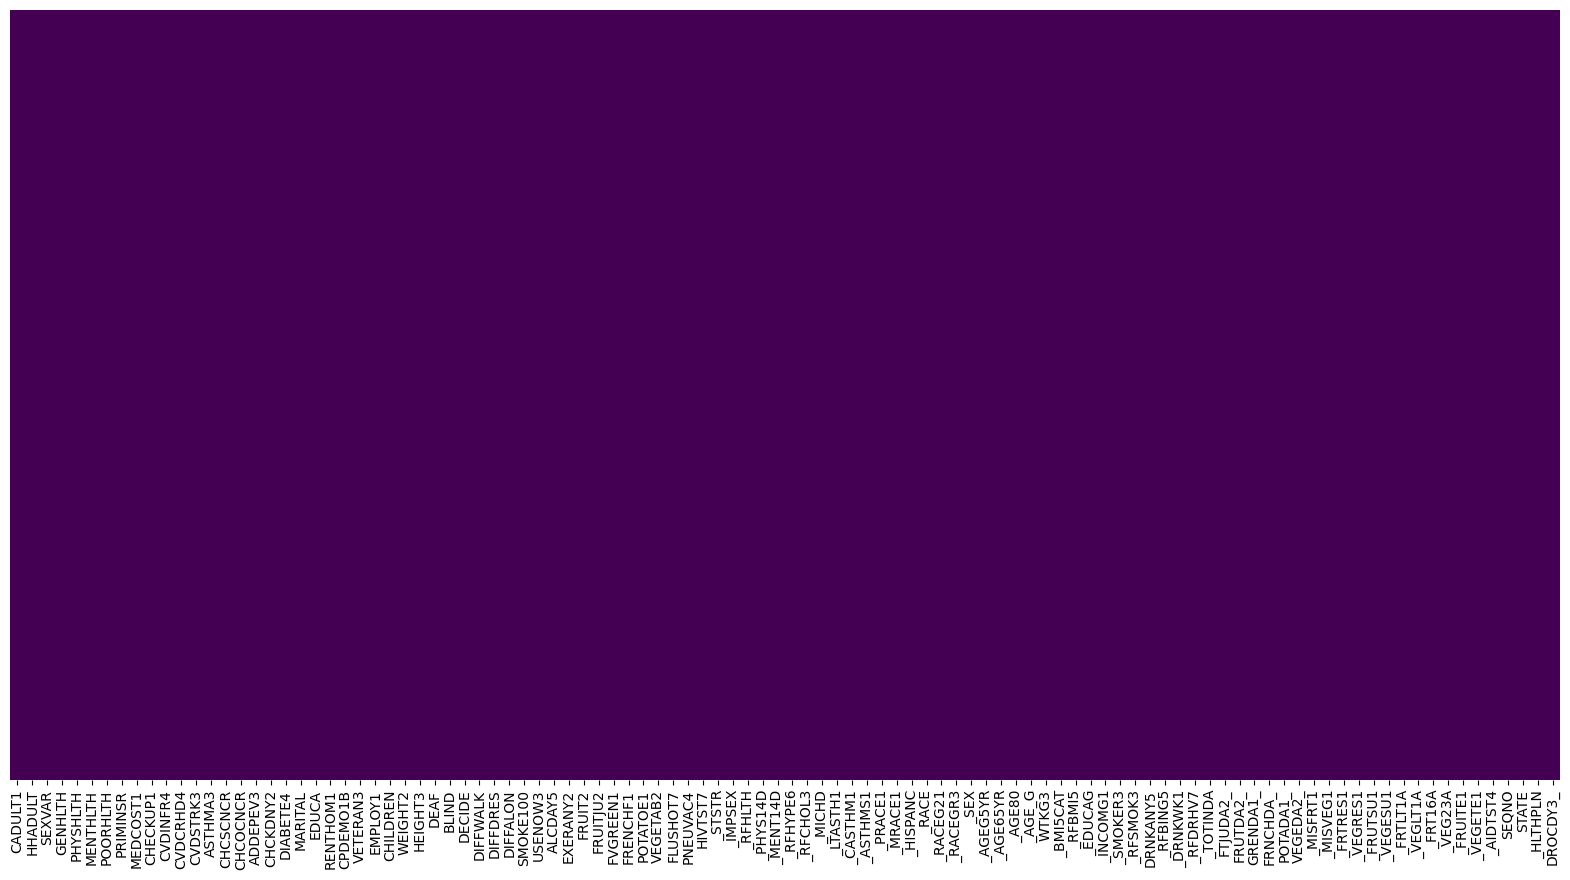

In [39]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [40]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
profile.to_file(output_file="mydata/2019_Cleaned.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54338 entries, 1 to 210771
Data columns (total 104 columns):
 #    Column    Non-Null Count  Dtype   
---   ------    --------------  -----   
 0    CADULT1   54338 non-null  category
 1    HHADULT   54338 non-null  float64 
 2    SEXVAR    54338 non-null  category
 3    GENHLTH   54338 non-null  object  
 4    PHYSHLTH  54338 non-null  float64 
 5    MENTHLTH  54338 non-null  float64 
 6    POORHLTH  54338 non-null  float64 
 7    PRIMINSR  54338 non-null  category
 8    MEDCOST1  54338 non-null  object  
 9    CHECKUP1  54338 non-null  object  
 10   CVDINFR4  54338 non-null  category
 11   CVDCRHD4  54338 non-null  category
 12   CVDSTRK3  54338 non-null  category
 13   ASTHMA3   54338 non-null  category
 14   CHCSCNCR  54338 non-null  category
 15   CHCOCNCR  54338 non-null  category
 16   ADDEPEV3  54338 non-null  category
 17   CHCKDNY2  54338 non-null  category
 18   DIABETE4  54338 non-null  object  
 19   MARITAL   54338 non-nu

In [42]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   54338.0  2.369944e+00      4.858832  1.000000e+00  1.000000e+00   
PHYSHLTH  54338.0  6.769830e+00      9.866643  0.000000e+00  0.000000e+00   
MENTHLTH  54338.0  7.506533e+00      9.649049  0.000000e+00  0.000000e+00   
POORHLTH  54338.0  5.191915e+01     39.389855  1.000000e+00  6.000000e+00   
CHILDREN  54338.0  5.802648e+01     41.041218  1.000000e+00  2.000000e+00   
WEIGHT2   54338.0  1.986724e+02    353.417569  5.500000e+01  1.500000e+02   
HEIGHT3   54338.0  1.706970e+00      0.105552  9.144000e-01  1.625600e+00   
FRUIT2    54338.0  1.895234e+02    117.403952  1.010000e+02  1.020000e+02   
FRUITJU2  54338.0  3.794656e+02    175.571969  1.010000e+02  2.030000e+02   
FVGREEN1  54338.0  2.436403e+02    122.473892  1.010000e+02  2.010000e+02   
FRENCHF1  54338.0  2.973530e+02    124.308143  1.010000e+02  2.020000e+02   
POTATOE1  54338.0  3.081518e+02    132.851054  1.010000e+02  2.020000e+02   
VEGETAB2  54338.0  2.041146e+02    117.048789  1.010000e+02  1.020000e+02   
_STSTR    54338.0  2.442145e+04  15135.942925  1.019000e+03  1.206900e+04   
_AGE80    54338.0  4.633446e+01     16.649618  1.800000e+01  3.200000e+01   
WTKG3     54338.0  8.388471e+01     22.222846  2.495000e+01  6.804000e+01   
_DRNKWK1  54338.0  1.105426e+03   8641.339334  0.000000e+00  0.000000e+00   
FTJUDA2_  54338.0  2.858662e-01      1.119794  0.000000e+00  0.000000e+00   
FRUTDA2_  54338.0  1.086705e+00      1.582945  0.000000e+00  4.000000e-01   
GRENDA1_  54338.0  5.695544e-01      1.175164  0.000000e+00  1.400000e-01   
FRNCHDA_  54338.0  2.417071e-01      0.588478  0.000000e+00  7.000000e-02   
POTADA1_  54338.0  2.222805e-01      0.544253  0.000000e+00  3.000000e-02   
VEGEDA2_  54338.0  9.609329e-01      1.560259  0.000000e+00  4.300000e-01   
_FRUTSU1  54338.0  1.369389e+00      2.012290  0.000000e+00  5.000000e-01   
_VEGESU1  54338.0  1.989920e+00      2.532647  0.000000e+00  1.130000e+00   
SEQNO     54338.0  2.019002e+09   1598.752582  2.019000e+09  2.019001e+09   
DROCDY3_  54338.0  1.773874e-01      0.266413  0.000000e+00  0.000000e+00   

                   50%           75%           99%           max  
HHADULT   2.000000e+00  3.000000e+00  6.000000e+00  9.900000e+01  
PHYSHLTH  2.000000e+00  8.000000e+00  3.000000e+01  3.000000e+01  
MENTHLTH  3.000000e+00  1.000000e+01  3.000000e+01  3.000000e+01  
POORHLTH  8.800000e+01  8.800000e+01  8.800000e+01  9.900000e+01  
CHILDREN  8.800000e+01  8.800000e+01  8.800000e+01  9.900000e+01  
WEIGHT2   1.800000e+02  2.100000e+02  3.440000e+02  9.265000e+03  
HEIGHT3   1.701800e+00  1.778000e+00  1.930400e+00  2.260600e+00  
FRUIT2    2.010000e+02  2.050000e+02  5.550000e+02  9.990000e+02  
FRUITJU2  3.070000e+02  5.550000e+02  5.550000e+02  9.990000e+02  
FVGREEN1  2.030000e+02  3.040000e+02  5.550000e+02  9.990000e+02  
FRENCHF1  3.010000e+02  3.050000e+02  5.550000e+02  9.990000e+02  
POTATOE1  3.020000e+02  3.080000e+02  5.550000e+02  9.990000e+02  
VEGETAB2  2.030000e+02  2.150000e+02  5.550000e+02  9.990000e+02  
_STSTR    2.401900e+04  3.801900e+04  5.102900e+04  5.210900e+04  
_AGE80    4.600000e+01  6.000000e+01  8.000000e+01  8.000000e+01  
WTKG3     8.165000e+01  9.525000e+01  1.542200e+02  2.766900e+02  
_DRNKWK1  4.700000e+01  3.730000e+02  8.400000e+03  9.990000e+04  
FTJUDA2_  3.000000e-02  2.900000e-01  3.000000e+00  9.000000e+01  
FRUTDA2_  1.000000e+00  1.000000e+00  5.000000e+00  9.200000e+01  
GRENDA1_  4.300000e-01  7.100000e-01  3.000000e+00  9.000000e+01  
FRNCHDA_  1.400000e-01  2.900000e-01  1.000000e+00  5.000000e+01  
POTADA1_  1.400000e-01  2.900000e-01  1.000000e+00  3.000000e+01  
VEGEDA2_  7.100000e-01  1.000000e+00  5.000000e+00  9.000000e+01  
_FRUTSU1  1.000000e+00  2.000000e+00  6.000000e+00  9.200000e+01  
_VEGESU1  1.600000e+00  2.290000e+00  8.140000e+00  1.200000e+02  
SEQNO     2.019001e+09  2.019002e+09  2.019007e+09  2.019008e+09  
DROCDY3_  6.666667e-02  2.666667e-01  1.000000

In [43]:
# Replace outliers with the 99 percentile value except weight column

num_cols = processed_features_df.select_dtypes(include=('float','int')).columns

for i in num_cols:
    percentile_99 = np.percentile(processed_features_df[i], 99)
    processed_features_df.loc[processed_features_df[i] > percentile_99, i] = percentile_99


In [44]:
processed_features_df['POORHLTH'] = processed_features_df['POORHLTH'].astype('category')

In [45]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   54338.0  2.130296e+00      1.050429  1.000000e+00  1.000000e+00   
PHYSHLTH  54338.0  6.769830e+00      9.866643  0.000000e+00  0.000000e+00   
MENTHLTH  54338.0  7.506533e+00      9.649049  0.000000e+00  0.000000e+00   
CHILDREN  54338.0  5.799409e+01     41.013200  1.000000e+00  2.000000e+00   
WEIGHT2   54338.0  1.847975e+02     47.790041  5.500000e+01  1.500000e+02   
HEIGHT3   54338.0  1.706509e+00      0.104393  9.144000e-01  1.625600e+00   
FRUIT2    54338.0  1.876399e+02    109.153732  1.010000e+02  1.020000e+02   
FRUITJU2  54338.0  3.775086e+02    172.110961  1.010000e+02  2.030000e+02   
FVGREEN1  54338.0  2.423166e+02    117.551000  1.010000e+02  2.010000e+02   
FRENCHF1  54338.0  2.960089e+02    119.953804  1.010000e+02  2.020000e+02   
POTATOE1  54338.0  3.060600e+02    126.802902  1.010000e+02  2.020000e+02   
VEGETAB2  54338.0  2.020555e+02    108.206924  1.010000e+02  1.020000e+02   
_STSTR    54338.0  2.441367e+04  15121.987755  1.019000e+03  1.206900e+04   
_AGE80    54338.0  4.633446e+01     16.649618  1.800000e+01  3.200000e+01   
WTKG3     54338.0  8.370497e+01     21.478172  2.495000e+01  6.804000e+01   
_DRNKWK1  54338.0  4.028973e+02   1054.625486  0.000000e+00  0.000000e+00   
FTJUDA2_  54338.0  2.517907e-01      0.477996  0.000000e+00  0.000000e+00   
FRUTDA2_  54338.0  1.043352e+00      0.948851  0.000000e+00  4.000000e-01   
GRENDA1_  54338.0  5.246239e-01      0.541747  0.000000e+00  1.400000e-01   
FRNCHDA_  54338.0  2.161955e-01      0.234417  0.000000e+00  7.000000e-02   
POTADA1_  54338.0  1.987263e-01      0.220557  0.000000e+00  3.000000e-02   
VEGEDA2_  54338.0  9.057255e-01      0.811781  0.000000e+00  4.300000e-01   
_FRUTSU1  54338.0  1.300715e+00      1.129137  0.000000e+00  5.000000e-01   
_VEGESU1  54338.0  1.889130e+00      1.299697  0.000000e+00  1.130000e+00   
SEQNO     54338.0  2.019002e+09   1586.889382  2.019000e+09  2.019001e+09   
DROCDY3_  54338.0  1.773874e-01      0.266413  0.000000e+00  0.000000e+00   

                   50%           75%           99%           max  
HHADULT   2.000000e+00  3.000000e+00  6.000000e+00  6.000000e+00  
PHYSHLTH  2.000000e+00  8.000000e+00  3.000000e+01  3.000000e+01  
MENTHLTH  3.000000e+00  1.000000e+01  3.000000e+01  3.000000e+01  
CHILDREN  8.800000e+01  8.800000e+01  8.800000e+01  8.800000e+01  
WEIGHT2   1.800000e+02  2.100000e+02  3.440000e+02  3.440000e+02  
HEIGHT3   1.701800e+00  1.778000e+00  1.930400e+00  1.930400e+00  
FRUIT2    2.010000e+02  2.050000e+02  5.550000e+02  5.550000e+02  
FRUITJU2  3.070000e+02  5.550000e+02  5.550000e+02  5.550000e+02  
FVGREEN1  2.030000e+02  3.040000e+02  5.550000e+02  5.550000e+02  
FRENCHF1  3.010000e+02  3.050000e+02  5.550000e+02  5.550000e+02  
POTATOE1  3.020000e+02  3.080000e+02  5.550000e+02  5.550000e+02  
VEGETAB2  2.030000e+02  2.150000e+02  5.550000e+02  5.550000e+02  
_STSTR    2.401900e+04  3.801900e+04  5.102900e+04  5.102900e+04  
_AGE80    4.600000e+01  6.000000e+01  8.000000e+01  8.000000e+01  
WTKG3     8.165000e+01  9.525000e+01  1.542200e+02  1.542200e+02  
_DRNKWK1  4.700000e+01  3.730000e+02  8.400000e+03  8.400000e+03  
FTJUDA2_  3.000000e-02  2.900000e-01  3.000000e+00  3.000000e+00  
FRUTDA2_  1.000000e+00  1.000000e+00  5.000000e+00  5.000000e+00  
GRENDA1_  4.300000e-01  7.100000e-01  3.000000e+00  3.000000e+00  
FRNCHDA_  1.400000e-01  2.900000e-01  1.000000e+00  1.000000e+00  
POTADA1_  1.400000e-01  2.900000e-01  1.000000e+00  1.000000e+00  
VEGEDA2_  7.100000e-01  1.000000e+00  5.000000e+00  5.000000e+00  
_FRUTSU1  1.000000e+00  2.000000e+00  6.000000e+00  6.000000e+00  
_VEGESU1  1.600000e+00  2.290000e+00  8.140000e+00  8.140000e+00  
SEQNO     2.019001e+09  2.019002e+09  2.019007e+09  2.019007e+09  
DROCDY3_  6.666667e-02  2.666667e-01  1.000000e+00  1.000000e+00

- We can see the presence of significant multicolinearity between the fruits and vegetable columns, which we will
look to remove further down the line 

#### Export the processed df out to be split into training and validation data

In [46]:
processed_features_df.to_csv('mydata/MMSA2019_Cleaned.csv', index=False)

### EXPLORATORY DATA ANALYSIS

<Axes: >

<Figure size 1200x800 with 0 Axes>

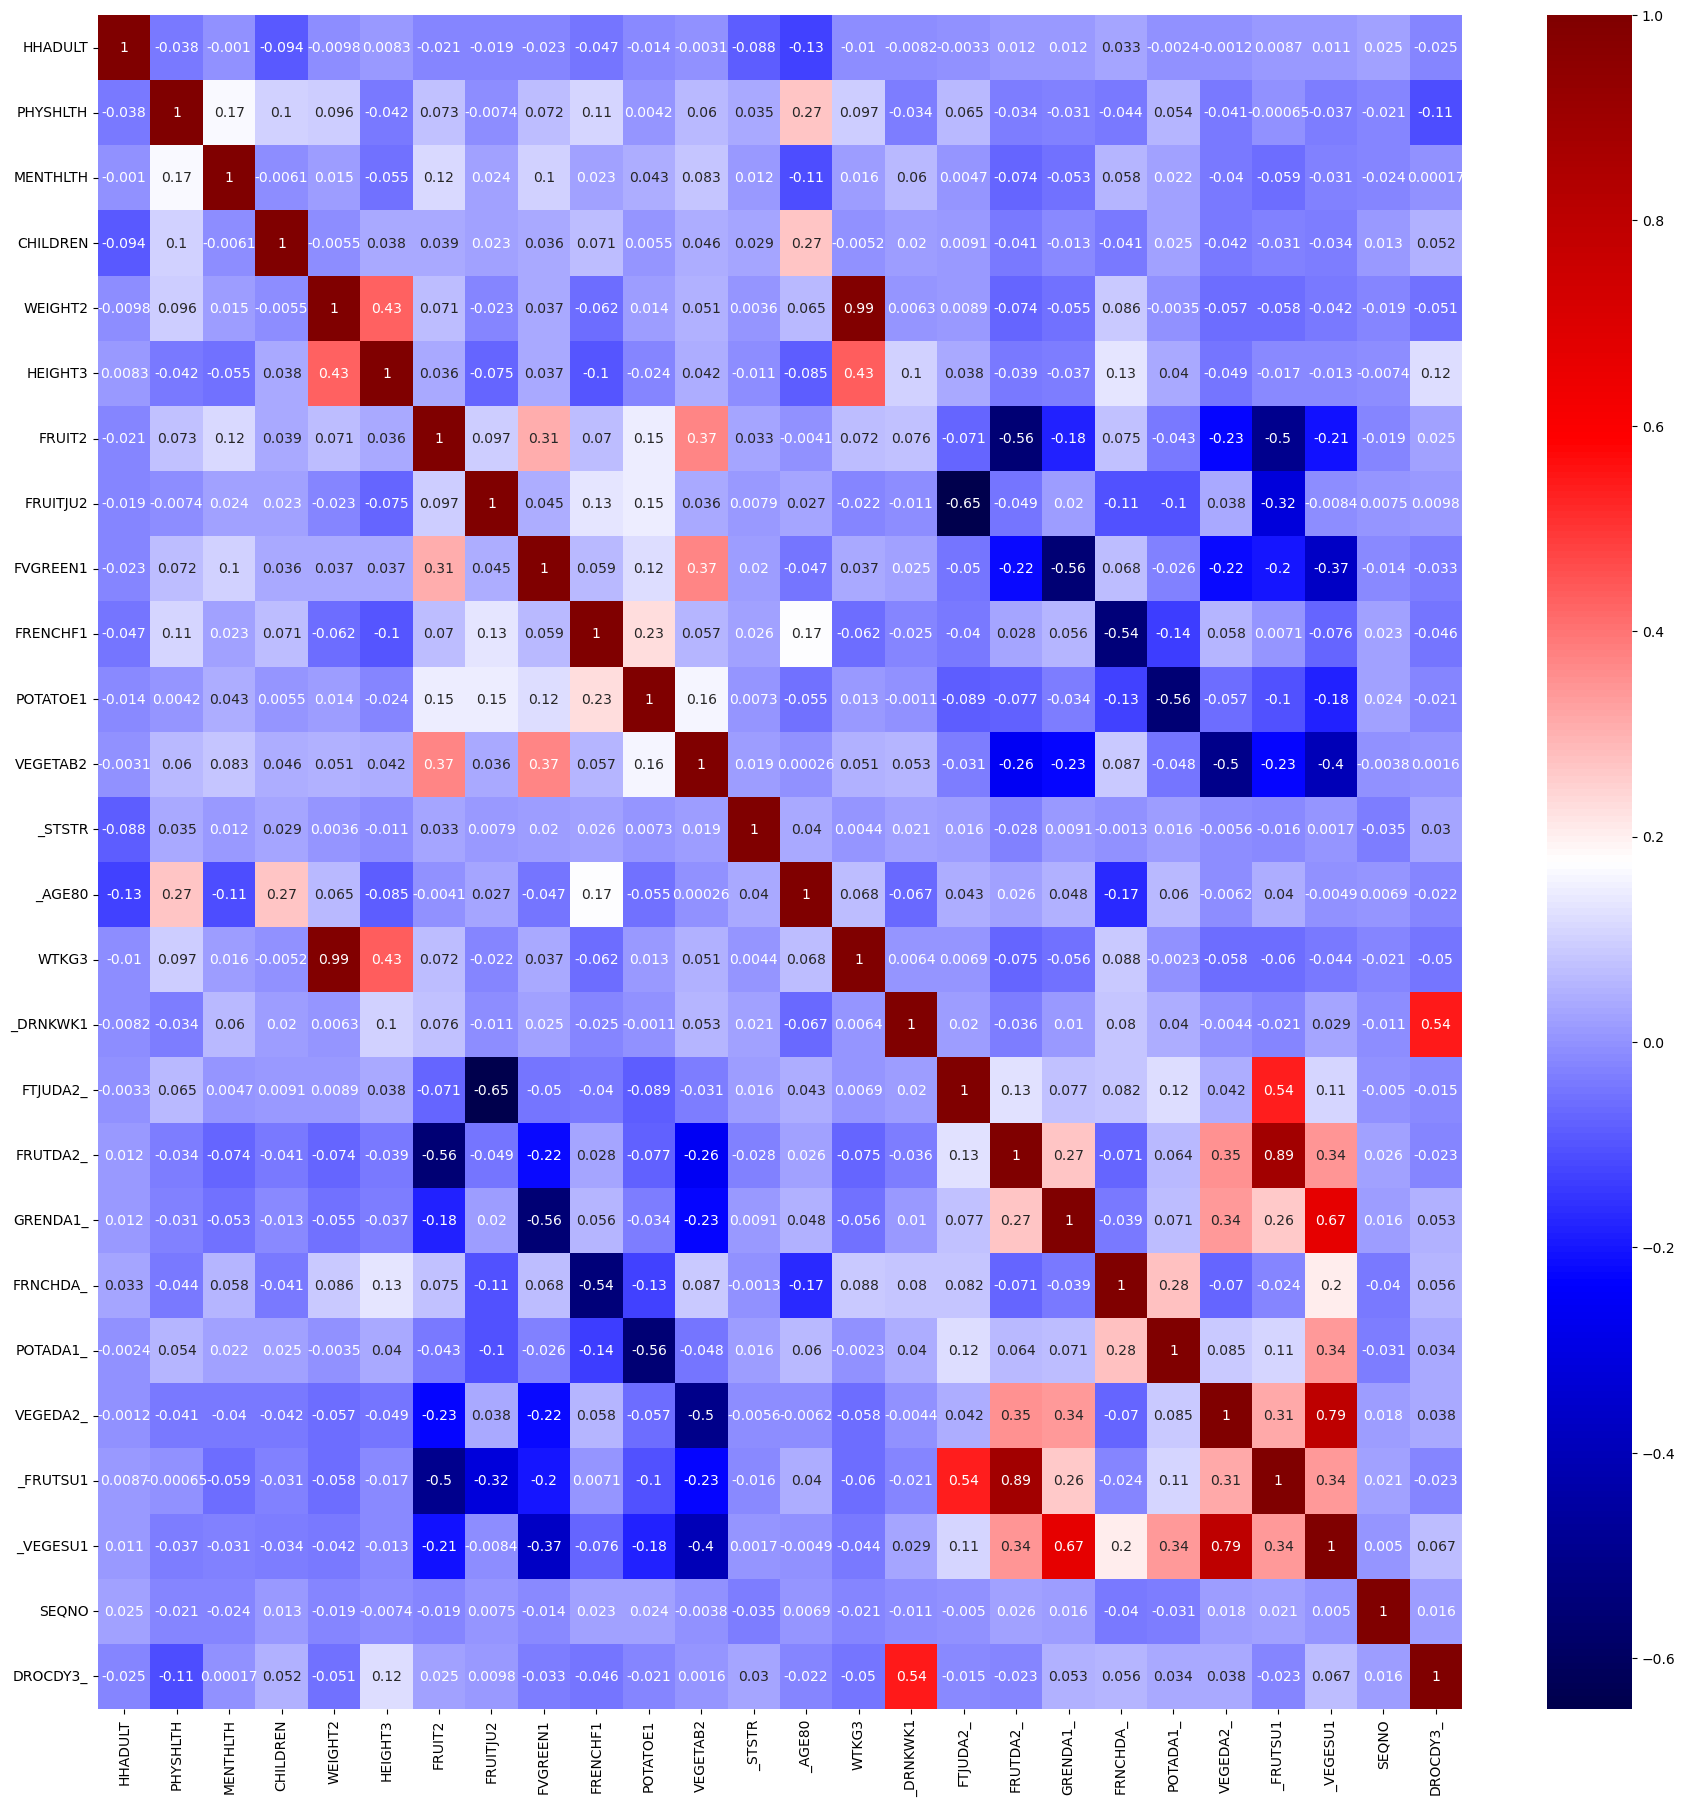

In [47]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='seismic',annot=True)

In [48]:
num_cols = processed_features_df.select_dtypes(include=('float','int')).columns
cat_cols = processed_features_df.select_dtypes(exclude=('float','int')).columns

In [49]:
cat_cols 

Index(['CADULT1', 'SEXVAR', 'GENHLTH', 'POORHLTH', 'PRIMINSR', 'MEDCOST1',
       'CHECKUP1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR',
       'CHCOCNCR', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'CPDEMO1B', 'VETERAN3', 'EMPLOY1', 'DEAF', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3',
       'ALCDAY5', 'EXERANY2', 'FLUSHOT7', 'PNEUVAC4', 'HIVTST7', '_IMPSEX',
       '_RFHLTH', '_PHYS14D', '_MENT14D', '_RFHYPE6', '_RFCHOL3', '_MICHD',
       '_LTASTH1', '_CASTHM1', '_ASTHMS1', '_PRACE1', '_MRACE1', '_HISPANC',
       '_RACE', '_RACEG21', '_RACEGR3', '_SEX', '_AGEG5YR', '_AGE65YR',
       '_AGE_G', '_BMI5CAT', '_RFBMI5', '_EDUCAG', '_INCOMG1', '_SMOKER3',
       '_RFSMOK3', 'DRNKANY5', '_RFBING5', '_RFDRHV7', '_TOTINDA', '_MISFRT1',
       '_MISVEG1', '_FRTRES1', '_VEGRES1', '_FRTLT1A', '_VEGLT1A', '_FRT16A',
       '_VEG23A', '_FRUITE1', '_VEGETE1', '_AIDTST4', 'STATE', '_HLTHPLN'],
      dtype='obj

In [50]:
#here we want to print out the value count in eah categorical column

# normalize used to get the percentage 
for i in list(cat_cols):
    print(processed_features_df[i].value_counts(normalize=True))
    print('**********************************')

1.0    1.0
Name: CADULT1, dtype: float64
**********************************
2    0.539291
1    0.460709
Name: SEXVAR, dtype: float64
**********************************
very good    0.323751
good         0.320954
fair         0.171997
excellent    0.122161
poor         0.061136
Name: GENHLTH, dtype: float64
**********************************
88.0    0.531875
2.0     0.070319
30.0    0.065534
1.0     0.062369
5.0     0.045327
3.0     0.043505
10.0    0.033844
15.0    0.032740
4.0     0.022728
7.0     0.021477
20.0    0.020409
14.0    0.009478
25.0    0.007398
6.0     0.006993
8.0     0.006036
77.0    0.005484
12.0    0.003055
21.0    0.002576
28.0    0.001288
9.0     0.001251
18.0    0.000920
29.0    0.000828
17.0    0.000718
16.0    0.000663
22.0    0.000607
27.0    0.000589
26.0    0.000478
11.0    0.000423
13.0    0.000405
23.0    0.000331
24.0    0.000276
19.0    0.000074
Name: POORHLTH, dtype: float64
**********************************
1.0    0.904211
2.0    0.093360
7.0    0.002172

height = height.tolist()
new_height = []
for row in height:
    h = str(row)

    if row < 1:
        meters = np.nan

    elif row < 712:
        feet = float(h[0])
        inches = float(h[1:])
        if inches > 12:
            meters = np.nan
        else:
            inches = inches + feet*12
            meters = inches * 0.0254

    elif row < 9999 and row >= 9000 and metric:
        meters = float(h[1])+float(h[2:])*0.01
        if meters == 0:
            meters = np.nan

    else:
        meters = np.nan

    new_height.append(meters)

weight = weight.tolist()
new_weight = []
for row in weight:
    
    if row < 10:
        kg = np.nan

    elif row < max_weight:
        kg = row * 0.453592
        
    elif row < 9999 and metric:
        w = str(row)
        kg = float(w[1:])
        if kg < 10:
            kg = np.nan

    else:
        kg = np.nan

    new_weight.append(kg)

bmi = []
for h, w in zip(new_height, new_weight):
    b = w/(h*h)
    if b < 10 or b > 200:
        b = np.nan
    bmi.append(b)

In [51]:
num_cols

Index(['HHADULT', 'PHYSHLTH', 'MENTHLTH', 'CHILDREN', 'WEIGHT2', 'HEIGHT3',
       'FRUIT2', 'FRUITJU2', 'FVGREEN1', 'FRENCHF1', 'POTATOE1', 'VEGETAB2',
       '_STSTR', '_AGE80', 'WTKG3', '_DRNKWK1', 'FTJUDA2_', 'FRUTDA2_',
       'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1', '_VEGESU1',
       'SEQNO', 'DROCDY3_'],
      dtype='object')

In [52]:
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [53]:
#lets create a new data frame with only dummmy categorical data and num columns 

dummies_df = processed_features_df[num_cols]

for i in cat_cols:
    temp = pd.get_dummies(processed_features_df[i],drop_first=True)
    dummies_df = pd.concat([dummies_df,temp],axis=1)

dummies_df.head()

HHADULT  PHYSHLTH  MENTHLTH  CHILDREN  WEIGHT2  HEIGHT3  FRUIT2  \
1        2.0       3.0       5.0      88.0    145.0   1.8288   205.0   
5        3.0      20.0       0.0      88.0    265.0   1.8034   303.0   
6        1.0       1.0       0.0      88.0    170.0   1.7272   203.0   
344      1.0       0.0       5.0      88.0    135.0   1.8034   210.0   
346      2.0       0.0      10.0       2.0    200.0   1.6256   102.0   

     FRUITJU2  FVGREEN1  FRENCHF1  ...  South Carolina  South Dakota  \
1       202.0     303.0     308.0  ...               0             1   
5       555.0     101.0     202.0  ...               0             1   
6       555.0     303.0     205.0  ...               0             1   
344     188.0     304.0     305.0  ...               0             1   
346     555.0     203.0     304.0  ...               0             1   

     Tennessee  Texas  Utah  Vermont  Virginia  Washington  West Virginia  \
1            0      0     0        0         0           0              0   
5            0      0     0        0         0           0              0   
6            0      0     0        0         0           0              0   
344          0      0     0        0         0           0              0   
346          0      0     0        0         0           0              0   

     Wisconsin  
1            0  
5            0  
6            0  
344          0  
346          0  

[5 rows x 368 columns]

In [54]:
dummies_df.columns = dummies_df.columns.astype(str)
processed_features_df.columns = processed_features_df.columns.astype(str)

In [55]:
X = dummies_df
y = processed_features_df['_RFHLTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [57]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

28

In [58]:
print(selected_feat)

Index(['PHYSHLTH', 'MENTHLTH', 'WEIGHT2', '_AGE80', 'WTKG3', '_VEGESU1',
       'fair', 'good', 'poor', 'very good', '30.0', '88.0', 'yes', '8.0',
       '2.0', '2.0', '2.0', '2.0', 'yes', '2', '3', '2', '2', '2.0', '4.0',
       '<15k', '>50k', '2.0'],
      dtype='object')
